# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model to data from [two deep mutational scanning experiments](https://github.com/dms-vep) across Delta and Omicron BA.1 Spike protein. This analysis is only run on a subset of the data for the purpose of this example. For more in-depth and advanced examples of the `multidms` interface, see the full analysis from our manuscript _Jointly modeling deep mutational scans identifies shifted mutational effects among SARS-CoV-2 spike homologs_, at https://matsengrp.github.io/SARS-CoV-2_spike_multidms/. 

In [1]:
import os
import sys
from collections import defaultdict
import time
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
import jax.numpy as jnp

import multidms
%matplotlib inline

## Inputs


You can initialize a `Data` object with a ``pd.DataFrame``
where each row is sampled variant with the following required columns:

1. **condition** - Experimental condition from
    which a sample measurement was obtained.
2. **aa_substitutions** - Defines each variant $v$ as a string of substitutions (e.g., 'M3A K5G').
    Note that while conditions may have differing wild types
    at a given site, the sites between conditions should reference
    the same site when alignment is performed between
    condition wild types. Finally, be sure wildtype variants have an empty string in this column
3. **func_score** - The functional score computed from experimental
    measurements.


In [2]:
func_score_df = pd.read_csv("func_score_df_delta_BA1_10K.csv").fillna("")
func_score_df

,func_score,aa_substitutions,condition
0,-0.9770,T29S V622M D1199Y,Delta-2
1,-0.1607,N87K A846S K947R T1117R L1203F,Delta-2
2,-3.5000,S46T Q506- A845R A879V N1192D,Delta-2
3,-1.9102,L10P V327F I1179V,Delta-2
4,1.0093,Q474H S686-,Delta-2
...,...,...,...
9995,0.8023,,Omicron_BA1-2
9996,0.3779,,Omicron_BA1-2
9997,-0.9409,V1176S,Omicron_BA1-2
9998,0.1793,A484L H1088Y,Omicron_BA1-2


Note that here we have multiple measurements for identical variants from individual barcode replicates

In [3]:
func_score_df.aa_substitutions.value_counts()

aa_substitutions
                      1567
D142S                    7
P26L                     7
T76I                     6
L368I                    6
                      ... 
E702V V736M              1
A1080V                   1
D178R P621R D796S        1
F329S K854N K1191T       1
N450D P479T              1
Name: count, Length: 7637, dtype: int64

## Instantiate and query `multidms.Data` object

In order to fit a model, we first need to prep our training data in the form of a `multidms.Data` object. We keep the static data object separate from the model objects so that multiple `multidms.Model` objects may effeciently share references to the same fitting data, thus minimizing the memory and computations required to prep and store the data. A full description of the options for data prep and the resulting object attributes are available via the API documentation, or directly from the python docstring directly via
```python
help(multidms.Data)
```

Next, we'll initialize the dataset using 'Delta-2' as the reference condition with the following parameter values
Upon instantiation the object performs the data preparation which can be summarized as:

1. Optionally, aggregating identical variants grouped by aa string and condition. 
2. Inferring the site map each condition, so as to identify the wildtype of the reference and non-identical sites for each non-reference condition.
3. Converting substitution string of non-reference condition variants to be with respect to a reference wildtype (if necessary). See the docstring for a more in-depth description and a toy example
4. Setting helpful _static_ attributes with helpful summaries of the data. We'll take a look at a few noteable attributes below.
5. initializing the raw training data as [binarymap](https://github.com/jbloomlab/binarymap) objects. Each condition will be associated with it's own `binarymap` which all share the same [allowed_subs](https://jbloomlab.github.io/binarymap/binarymap.binarymap.html?highlight=allowed).

In [4]:
data = multidms.Data(
    func_score_df,
    alphabet = multidms.AAS_WITHSTOP_WITHGAP, # AAS, AA_WITHSTOP, AA_WITHGAP, or AA_WITHSTOP_WITHGAP
    collapse_identical_variants = "mean", # False, "median"
    reference = "Delta-2", # any condition
    verbose = True, # progress bars
    nb_workers=4 # threads
)

inferring site map for Delta-2


  0%|          | 0/4094 [00:00<?, ?it/s]

inferring site map for Omicron_BA1-2


  0%|          | 0/3764 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1007, 412, 865, 824, 774, 736, 347, 302, 559, 313, 1039, 991, 663, 419, 864, 418, 70, 805, 144, 319, 69, 916, 1053, 978, 143, 211, 301, 361, 379, 432, 538, 700, 637, 592, 145, 1218, 509, 877, 669, 278, 355, 360, 325, 776, 398, 40, 980, 456, 745, 584, 1145, 1062, 321, 194, 561, 497, 693, 543, 975, 906, 822, 931, 454, 295, 296, 437, 495, 434, 624, 742, 424, 873, 802, 972, 223, 270, 425, 461, 48, 753, 966, 974, 125, 786, 953, 524, 777, 500, 548, 380, 507, 914, 610, 130, 755, 433, 297, 377, 1119, 383, 698, 730, 531, 1031, 602, 763, 492, 695, 511, 1064, 525, 781, 760, 904, 526, 896, 964, 898, 157, 806, 1154, 467, 191, 1003, 833, 872, 416, 431, 891, 557, 729, 233, 887, 923, 965, 562, 816, 997, 959, 122, 158, 343, 726, 546, 749, 782, 728, 1011, 480, 992, 665, 905, 599, 928, 581, 696, 541, 236, 421, 756, 917, 91],
dropping: 567 variantswhich have mutations at those sites.


invalid non-identical-sites: [212, 371, 375, 417, 452, 477, 484, 493, 498, 981], dropping 475 variants
Converting mutations for Delta-2
is reference, skipping
Converting mutations for Omicron_BA1-2


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Let's take a look at a few attributes now available through the data object.

`Data.site_map` gives us the wildtype sequence inferred from each observed substitutions observed in the data separately for each condition.

In [5]:
data.site_map.head()

,Delta-2,Omicron_BA1-2
1,M,M
2,F,F
3,V,V
4,F,F
5,L,L


While the site map above gives the entire wildtype for each condition, we can easily view the sites for which a given condition wildtype differs from that of the reference via `Data.non_identical_sites`.

In [6]:
data.non_identical_sites['Omicron_BA1-2'].head()

,Delta-2,Omicron_BA1-2
19,R,T
67,A,V
95,T,I
156,G,E
339,G,D


The set of all mutations we are able to learn about with this model is defined by all mutations seen across all variants, for all condition groups combined. Mutations observed at non-identical sites on non-reference condition variants are converted to be with respect to the reference wildtype at that site, in other words they are treated, reported, and encoded in the binarymap as if the substitution had occured on the reference background. To get a succinct tuple of all mutations seen in the data, we can use `Data.mutations` attribute

In [7]:
data.mutations[:5]

('M1I', 'M1-', 'F2L', 'F2Y', 'V3F')

Perhaps more useful, `multidms.Data.mutations_df` gives more mutation-specific details, primarily the number of variant backgrounds any givem mutation has been seen on, for each condition.

In [8]:
data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-2,times_seen_Omicron_BA1-2
0,M1I,M,1,I,0.0,1.0
1,M1-,M,1,-,1.0,0.0
2,F2L,F,2,L,1.0,1.0
3,F2Y,F,2,Y,1.0,0.0
4,V3F,V,3,F,1.0,4.0


`Data.variants_df` gives us all variants after the various data prepping options such as barcode aggregation, have been applied. See the API documentation for more.

In [9]:
data.variants_df.head()

,condition,aa_substitutions,weight,func_score,var_wrt_ref
0,Delta-2,,599,-0.15963,
1,Delta-2,A1016S,1,-1.29760,A1016S
2,Delta-2,A1016T,1,-0.88240,A1016T
3,Delta-2,A1016T K1191L,1,-0.03900,A1016T K1191L
4,Delta-2,A1020C,1,0.50800,A1020C


The 'weight' column above gives the number of barcodes that were seen for a given variant before they and their respective functional scores were aggregated. The 'var_wrt_ref' columns shows the converted 'aa_substitutions' to be with respect to the reference as described above. Above, we just see a few reference variants, thus there is no conversion applied. Let's look at a non-reference condition variant with a non-identical site mutation.

In [10]:
data.variants_df.query("condition == 'Omicron_BA1-2' and aa_substitutions.str.contains('212')").head()

,condition,aa_substitutions,weight,func_score,var_wrt_ref
6545,Omicron_BA1-2,Q23L I285F W633R W1212L,1,-3.5000,R19T A67V T95I G156E G339D S373P N440K G446S G...
6831,Omicron_BA1-2,S162I W1212L,1,-2.1074,R19T A67V T95I G156E G339D S373P N440K G446S G...


In the conversion, we see all that the "bundle" of mutations which distinguish Omicron BA1 from Delta are now encoded as if they were simply mutations seen on a Delta background with some exceptions. Notice that the variant at index $4116$ had a "I212A" mutation. That mutation is now encoded as "L212A", which exemplifies a substitution that has been converted to be with respect to the reference wildtype, "L", at site 212. Conversly, if the mutation at a non-identical site results in homology with the reference wildtype, then that site's subsitutions is left out completely from the conversion. For examplem, the variant at index $4458$ contains the substitution "I212L", but there is no 212 substitution observed in the respective conversion.

## Instantiate and fit `multidms.Model` object

Next, we create a model object which initializes and stores the model parameters. These parameters are determined primarily by the substitutions observed in the data, and the (post-latent) epistatic / output activation functions you choose. A full description of the options for models and the resulting object attributes are available via the API documentation, or directly from the python docstring directly via
```python
help(multidms.Model)
```

In [11]:
model = multidms.Model(data)

In [12]:
start = time.time()
model.fit(lasso_shift=2e-4, maxiter=15000, tol=1e-6)
end = time.time()
print(f"done. fitting time = {round(end - start, 2)} seconds")

done. fitting time = 440.68 seconds


The Model object allows provides many of the same properties, like mutations and variants dataframes, but add additional features relavent to the parameters of this model. `Model.get_mutations_df` returns the associated data object's mutations_df as seen above, along with the $\beta$ and $S_{m,h}$ parameter's associated with each mutation. 

In [14]:
help(multidms.Model.get_mutations_df)

Help on function get_mutations_df in module multidms.model:

get_mutations_df(self, phenotype_as_effect=True)
    Mutation attributes and phenotypic effects.
    
    Parameters
    ----------
    phenotype_as_effect : bool
        if True, phenotypes (both latent, and func_score)
        are calculated as the _difference_ between predicted
        phenotype of a given variant and the respective experimental
        wildtype prediction. Otherwise, report the unmodified
        model prediction.
    
    Returns
    -------
    pandas.DataFrame
        A copy of the mutations data, `self.data.mutations_df`,
        with the mutations column set as the index, and columns
        with the mutational attributes (e.g. betas, shifts) and
        conditional phenotypes (e.g. func_scores) added.
        Phenotypes are predicted
        based on the current state of the model.



In [15]:
model.get_mutations_df(phenotype_as_effect=False).head()

,wts,sites,muts,times_seen_Delta-2,times_seen_Omicron_BA1-2,beta,Delta-2_predicted_func_score,shift_Omicron_BA1-2,Omicron_BA1-2_predicted_func_score
mutation,,,,,,,,,
M1I,M,1,I,0.0,1.0,-4.021902,0.127049,-0.0,-3.401640
M1-,M,1,-,1.0,0.0,-13.329159,-3.392310,0.0,-3.403426
F2L,F,2,L,1.0,1.0,3.442455,0.231449,0.0,-1.724901
F2Y,F,2,Y,1.0,0.0,6.410191,0.231507,0.0,0.025978
V3F,V,3,F,1.0,4.0,-5.243893,-0.100204,-0.0,-3.402900


Similarly, `Model.get_variants_df` now provides the latent ($z$) and functional score ($\hat{y}_{v, h}$) predictions as well as gamma-corrected functional score ($y'_{v, h}$). See the Biophysical documention for more. Note that for the reference condition, $\gamma_{h}$ is always equal to $0$, and thus the functional score is always equal to the gamma corrected functional scores for these variants.

In [18]:
help(multidms.Model.get_variants_df)

Help on function get_variants_df in module multidms.model:

get_variants_df(self, phenotype_as_effect=True)
    Training data with model predictions for latent,
    and functional score phenotypes.
    
    Parameters
    ----------
    phenotype_as_effect : bool
        if True, phenotypes (both latent, and func_score)
        are calculated as the _difference_ between predicted
        phenotype of a given variant and the respective experimental
        wildtype prediction. Otherwise, report the unmodified
        model prediction.
    
    Returns
    -------
    pandas.DataFrame
        A copy of the training data, `self.data.variants_df`,
        with the phenotypes added. Phenotypes are predicted
        based on the current state of the model.



In [19]:
model.get_variants_df(phenotype_as_effect=False).head()

,condition,aa_substitutions,weight,func_score,var_wrt_ref,predicted_latent,predicted_func_score
0,Delta-2,,599,-0.15963,,7.542272,0.229584
1,Delta-2,A1016S,1,-1.29760,A1016S,0.274442,-1.338117
2,Delta-2,A1016T,1,-0.88240,A1016T,8.827775,0.230977
3,Delta-2,A1016T K1191L,1,-0.03900,A1016T K1191L,3.167121,0.084579
4,Delta-2,A1020C,1,0.50800,A1020C,13.549971,0.231505


## Visualization

Now that we have some fit parameters, There exists a few useful plotting methods for the Model object. Each plotting method will either populate a provided `matplotlib.axes` object provided, or generate it's own. For a full description of the plotting methods please see the API documentation.

First, let's take a look at the prediction accuracy on all training data as well as the global epistasis fit

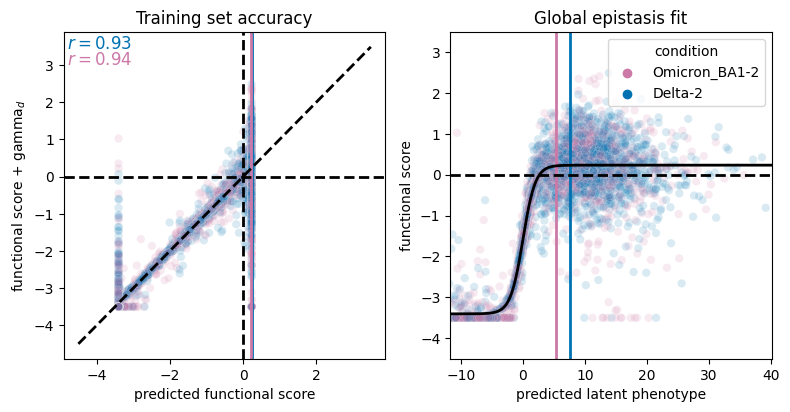

In [25]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
model.plot_epistasis(ax=ax[1], alpha=0.15, show=False, legend=True)
model.plot_pred_accuracy(ax=ax[0], alpha=0.15, show=False, legend=False)
ax[1].set_title("Global epistasis fit")
ax[0].set_title("Training set accuracy")
plt.show()

We can also take a quick look at the distribution of any parameter set in the model. Below we'll take a look at the distribution of shift parameters for the non reference BA1 condition. The distribution, by default, splits the shifts associated with stop codon mutations as a sanity check for the model fit. We expect stop codons to be equally deleterious no matter which condition they occur in, and thus, they should primarily be zero.

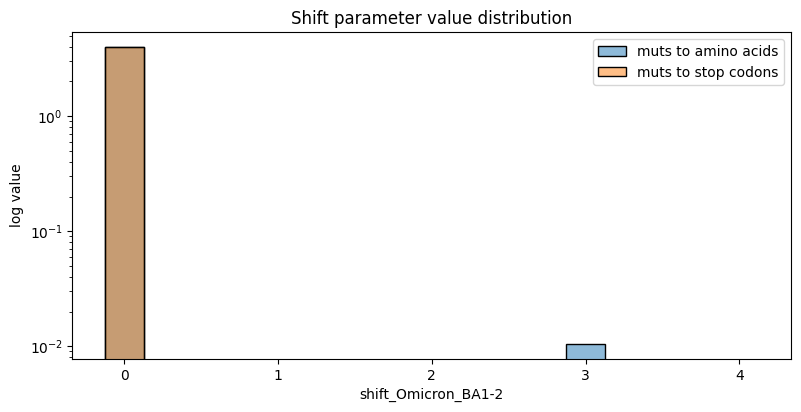

In [26]:
fig, ax = plt.subplots(figsize=[8,4])
agg_func = lambda x: onp.abs(onp.mean(onp.sum(x)))
model.plot_param_hist("shift_Omicron_BA1-2", ax=ax, show=False)
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("log value")
ax.set_title("Shift parameter value distribution")
plt.show()

Additionally, we offer the ability to interactively visualize a model's shift parameters using the `Model.mut_shift_plot()` method which calls to a modified function from the original `polyclonal.plot.lineplot_and_heatmap()` as seen [here](https://github.com/jbloomlab/polyclonal/blob/92fee4badb14e1db719074f202b4fab374dd0613/polyclonal/plot.py#L263). Currently, the heatmaps place an "X" at the wildtype for the reference sequence only. All non-identical wildtypes are marked with dot, on the respective shifts parameter heatmap, in the respective condition color at the correct wildtype position.

In [27]:
model.mut_param_heatmap()

alt.VConcatChart(...)

Finally, we can save the tuned model via `pickle`

In [28]:
import pickle
pickle.dump(model, open("test_dump.pkl","wb"))